# Linear Sweep Search

In this file I develop an algorithm to search the carpal tunnel along one axis 

In [1]:
# import
import os
import logging
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from nibabel.testing import data_path
from scipy.ndimage import label

from visualization_utils import show, show_slices

# Set up the logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

Load the dataset

In [2]:
mri_1_label = nib.load('MRI/Labels/final/LabelsDani.nii')
mri_1_label_data = mri_1_label.get_fdata()
mri_1_label_data.shape

(606, 864, 61)

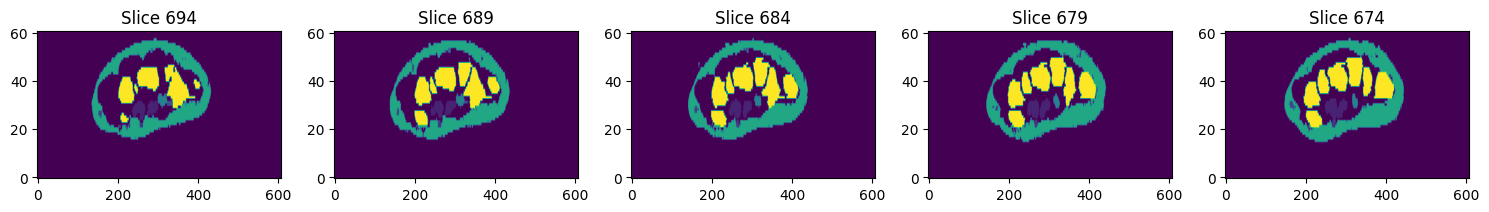

In [3]:
show_slices(mri_1_label_data,  mri_1_label_data.shape[1]-170, 5, 5)

In [4]:
np.savetxt("carpal_values.txt", mri_1_label_data[:, 679, :], fmt='%.3f')

In [5]:
tissues = { "bone": 20,
            "ligaments": 2,
            "ulnar": 3,}


In [6]:
def find_clusters(tissue_value: int, slice: np.ndarray) -> list[dict]:
    # Create a binary mask based on the threshold
    binary_mask = (slice == tissue_value)

    # Label connected components in the binary mask
    labeled_array, num_clusters = label(binary_mask)

    # Extract clusters and their centers
    cluster_data = []
    
    for cluster_label in range(num_clusters):
        cluster_indices = np.where(labeled_array == cluster_label+1)
        # Calculate the center of the cluster
        center_x = np.mean(cluster_indices[0])
        center_y = np.mean(cluster_indices[1])
        center = (center_x, center_y)

        # Save both the cluster and center under the same key
        cluster_data.append({'cluster': list(zip(cluster_indices[0], cluster_indices[1])),
                                       'center': center})

    return cluster_data

In [7]:
def cluster_iter(tissues: dict, slice: np.ndarray) -> dict:
    # store clsuters of tissues in a dict
    tissues_clusters = {}
    
    for tissue in tissues:
        print(f"Finding {tissue} clusters, with value {tissues[tissue]}:")
        tissues_clusters[tissue] = (find_clusters(tissues[tissue], slice))

        # print the identified clusters and their centers
        for index, data in enumerate(tissues_clusters[tissue]):
            print(f"Center of {tissue} cluster {index}: {data['center']}")
    print("---------------------------------------\n")     
    return tissues_clusters

In [8]:
def show_clusters(tissues: dict, slice: np.ndarray) -> None:
    tissue_clusters = cluster_iter(tissues, slice)

    for tissue in tissues:
        for _, data in enumerate(tissue_clusters[tissue]):
            plt.scatter(*data['center'], color='red', marker='*', s=20)

    plt.imshow(slice.T, aspect=6, origin='lower')

    plt.show()

Finding bone clusters, with value 20:
Center of bone cluster 0: (216.32584269662922, 34.07303370786517)
Center of bone cluster 1: (219.5589519650655, 24.148471615720524)
Center of bone cluster 2: (243.7093023255814, 38.54651162790697)
Center of bone cluster 3: (280.0227790432802, 41.264236902050115)
Center of bone cluster 4: (321.69170984455957, 43.89637305699482)
Center of bone cluster 5: (350.951367781155, 37.82674772036474)
Center of bone cluster 6: (394.2334217506631, 37.54641909814324)
Finding ligaments clusters, with value 2:
Center of ligaments cluster 0: (261.43956043956047, 28.208791208791208)
Center of ligaments cluster 1: (288.9507042253521, 28.485915492957748)
Finding ulnar clusters, with value 3:
Center of ulnar cluster 0: (267.5833333333333, 22.25)
---------------------------------------



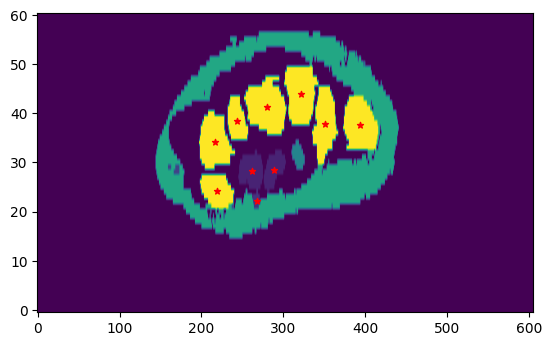

In [9]:
show_clusters(tissues, mri_1_label_data[:, 679, :])

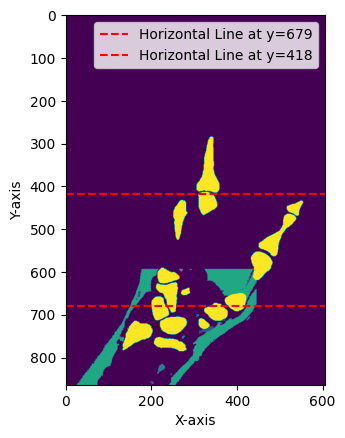

In [10]:
# Draw a horizontal line at y=n
plt.axhline(y=679, color='red', linestyle='--', label=f'Horizontal Line at y={679}')
plt.axhline(y=418, color='red', linestyle='--', label=f'Horizontal Line at y={418}')

plt.imshow(mri_1_label_data[:, :, 35].T, label='Hand')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

plt.show()

Finding bone clusters, with value 20:
Center of bone cluster 0: (207.85616438356163, 18.267123287671232)
Center of bone cluster 1: (268.67952522255194, 28.35311572700297)
Center of bone cluster 2: (323.5089605734767, 38.272401433691755)
Center of bone cluster 3: (322.5, 33.0)
Center of bone cluster 4: (414.9977777777778, 40.2)
Center of bone cluster 5: (561.9555555555555, 38.08888888888889)
Finding ligaments clusters, with value 2:
Finding ulnar clusters, with value 3:
---------------------------------------



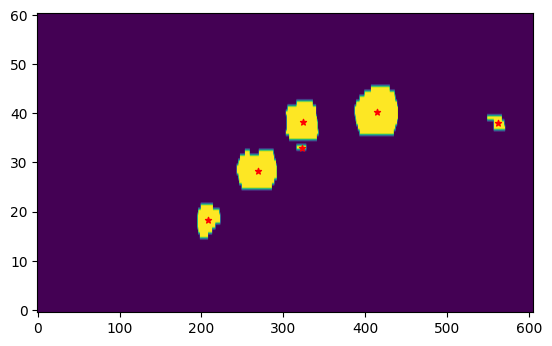

In [11]:
show_clusters(tissues, mri_1_label_data[:, 418, :])

In [12]:
finger_clusters = cluster_iter(tissues, mri_1_label_data[:, 418, :])
print(len(finger_clusters['ligaments']))

Finding bone clusters, with value 20:
Center of bone cluster 0: (207.85616438356163, 18.267123287671232)
Center of bone cluster 1: (268.67952522255194, 28.35311572700297)
Center of bone cluster 2: (323.5089605734767, 38.272401433691755)
Center of bone cluster 3: (322.5, 33.0)
Center of bone cluster 4: (414.9977777777778, 40.2)
Center of bone cluster 5: (561.9555555555555, 38.08888888888889)
Finding ligaments clusters, with value 2:
Finding ulnar clusters, with value 3:
---------------------------------------

0


In [13]:
def loss_fct(tissues: dict, slice: np.ndarray) -> float:
    
    tissue_clusters = cluster_iter(tissues, slice)

    print('####################################################')
    print("Calculating loss function:")

    # Presence of landmark tissues:
    
    # Standard plane has 7 bone, 2 ligaments and 1 ulnar cluster
    bone_loss = abs(len(tissue_clusters['bone']) - 7)
    ligament_loss = abs(len(tissue_clusters['ligaments']) - 2)
    ulnar_loss = abs(len(tissue_clusters['ulnar']) - 1)

    landmark_loss = bone_loss + ligament_loss + ulnar_loss

    # Absence of landmarks:
    missing_landmark_loss = 0

    # Location of landmarks:
    location_loss = 2

    # There must be bones:
    if len(tissue_clusters['bone'])!=0:
        
        # Get centers of tissue clusters:
        bone_centers = [cluster['center'] for _, cluster in enumerate(tissue_clusters['bone'])]
        bone_centers_mean = np.mean(bone_centers, axis=0)

        # There must be ligaments:
        if len(tissue_clusters['ligaments'])!=0:

            # Get centers of tissue clusters:
            ligament_centers = [cluster['center'] for _, cluster in enumerate(tissue_clusters['ligaments'])]
            ligament_centers_mean = np.mean(ligament_centers, axis=0)

            # Check the orientation of the arm:
            # The bones center might be over or undere the ligaments center depending on the origin
            if bone_centers_mean[1] > ligament_centers_mean[1]:
                print("Orientation: bones over ligaments")
                orientation = -1
            else: 
                print("Orientation: bones under ligaments")
                orientation = 1
            
            # Ligaments must be over bones in the positive orientation:
            if orientation * bone_centers_mean[1] > orientation * ligament_centers_mean[1]: 
                print("Ligaments center not where excpected")
            else: location_loss -= 1


            # There must be one ulnar artery:
            if len(tissue_clusters['ulnar'])==1:
                
                # There must be only one ulnar tissue so there is no need to take the mean
                ulnar_center = tissue_clusters['ulnar'][0]['center']

                # Ulnar artery must be over ligaments in the positive orientation:
                if orientation * ulnar_center[1] < orientation * ligament_centers_mean[1]: 
                    print("Ulnar center not where excpected")
                else: location_loss -= 1
            
            # if no ulnar artery
            else: 
                missing_landmark_loss += 1
                print("No ulnar artery found")
        # if no ligaments
        else: 
            missing_landmark_loss += 2
            print("No ligaments found")
    # if no bones:
    else: 
        missing_landmark_loss += 3
        print("No bones found")

    # Loss is bounded between 0 and 1
    loss = (1/3)*(0.1*landmark_loss + (1/3)*missing_landmark_loss + 0.5*location_loss)

    print(f"Landmark loss: {landmark_loss}")
    print(f"Missing landmark loss: {missing_landmark_loss}")
    print(f"Location loss: {location_loss}")
    print(f"Total loss: {loss}")

    print('#################################################### \n')

    return loss

In [14]:
clusters = cluster_iter(tissues, mri_1_label_data[:, 679, :])

bone_centers = [cluster['center'] for _, cluster in enumerate(clusters['bone'])]
ligament_centers = [cluster['center'] for _, cluster in enumerate(clusters['ligaments'])]

bone_center = np.mean(bone_centers, axis=0)
print("bone_center: ", bone_center)
ligament_center = np.mean(ligament_centers, axis=0)
print("ligament_center: ", ligament_center)
ulnar_center = clusters['ulnar'][0]['center']
print("ulnar_center: ", ulnar_center)

Finding bone clusters, with value 20:
Center of bone cluster 0: (216.32584269662922, 34.07303370786517)
Center of bone cluster 1: (219.5589519650655, 24.148471615720524)
Center of bone cluster 2: (243.7093023255814, 38.54651162790697)
Center of bone cluster 3: (280.0227790432802, 41.264236902050115)
Center of bone cluster 4: (321.69170984455957, 43.89637305699482)
Center of bone cluster 5: (350.951367781155, 37.82674772036474)
Center of bone cluster 6: (394.2334217506631, 37.54641909814324)
Finding ligaments clusters, with value 2:
Center of ligaments cluster 0: (261.43956043956047, 28.208791208791208)
Center of ligaments cluster 1: (288.9507042253521, 28.485915492957748)
Finding ulnar clusters, with value 3:
Center of ulnar cluster 0: (267.5833333333333, 22.25)
---------------------------------------

bone_center:  [289.49905363  36.7573991 ]
ligament_center:  [275.19513233  28.34735335]
ulnar_center:  (267.5833333333333, 22.25)


In [15]:
loss_fct(tissues, mri_1_label_data[:, 679, :])

Finding bone clusters, with value 20:
Center of bone cluster 0: (216.32584269662922, 34.07303370786517)
Center of bone cluster 1: (219.5589519650655, 24.148471615720524)
Center of bone cluster 2: (243.7093023255814, 38.54651162790697)
Center of bone cluster 3: (280.0227790432802, 41.264236902050115)
Center of bone cluster 4: (321.69170984455957, 43.89637305699482)
Center of bone cluster 5: (350.951367781155, 37.82674772036474)
Center of bone cluster 6: (394.2334217506631, 37.54641909814324)
Finding ligaments clusters, with value 2:
Center of ligaments cluster 0: (261.43956043956047, 28.208791208791208)
Center of ligaments cluster 1: (288.9507042253521, 28.485915492957748)
Finding ulnar clusters, with value 3:
Center of ulnar cluster 0: (267.5833333333333, 22.25)
---------------------------------------

####################################################
Calculating loss function:
Orientation: bones over ligaments
Landmark loss: 0
Missing landmark loss: 0
Location loss: 0
Total loss: 0

0.0

In [16]:
sweep_loss = []

for i in range(mri_1_label_data.shape[1]):
    sweep_loss.append(loss_fct(tissues, mri_1_label_data[:, i, :]))
    

Finding bone clusters, with value 20:
Finding ligaments clusters, with value 2:
Finding ulnar clusters, with value 3:
---------------------------------------

####################################################
Calculating loss function:
No bones found
Landmark loss: 10
Missing landmark loss: 3
Location loss: 2
Total loss: 1.0
#################################################### 

Finding bone clusters, with value 20:
Finding ligaments clusters, with value 2:
Finding ulnar clusters, with value 3:
---------------------------------------

####################################################
Calculating loss function:
No bones found
Landmark loss: 10
Missing landmark loss: 3
Location loss: 2
Total loss: 1.0
#################################################### 

Finding bone clusters, with value 20:
Finding ligaments clusters, with value 2:
Finding ulnar clusters, with value 3:
---------------------------------------

####################################################
Calculating loss f

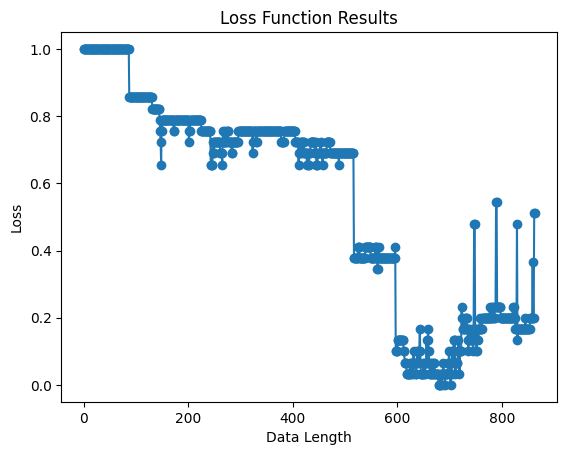

In [17]:
# Plot the loss results over the length of the data
plt.plot(range(len(sweep_loss)), sweep_loss, marker='o')

# Add labels and title
plt.xlabel('Data Length')
plt.ylabel('Loss')
plt.title('Loss Function Results')

# Show the plot
plt.show()

In [18]:
# Find indices where the loss is equal to 0
zero_loss_indices = np.where(np.array(sweep_loss) == 0)[0]
print(f"{len(zero_loss_indices)} indices return a zero loss: ", zero_loss_indices)

7 indices return a zero loss:  [679 680 681 682 685 691 702]


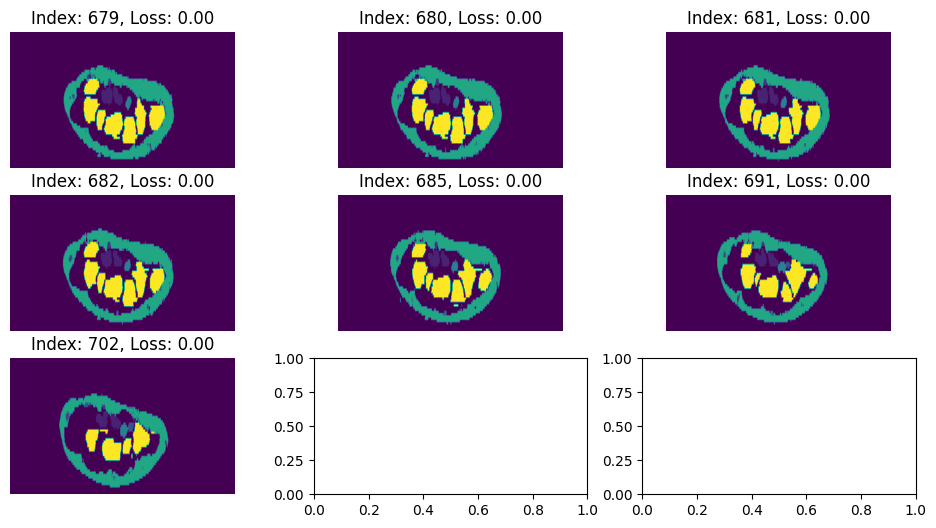

In [19]:
# Create a subplot for each image with 0 loss
fig, axes = plt.subplots(3, 3, figsize=(12, 6))

axes = axes.flatten()
for i, idx in enumerate(zero_loss_indices):
    # Plot the image
    axes[i].imshow(mri_1_label_data[:, idx, :].T, aspect=6)
    axes[i].set_title(f'Index: {idx}, Loss: {sweep_loss[idx]:.2f}')
    axes[i].axis('off')

plt.show()

The slices from 679:682 show good results.
The slices right before or right after this optimal range are excluded because the loss function is strictly penalizing the cluster size of bones and ligaments. 
In fact, 683:690 might all be accepted, but two bone clusters are too close to be distinguished.
Same problem from 670:679, where the ligaments form only one cluster instead of two.

685 is an exception, since a small bone cluster is missclassified.

691 and 702 are outliers that should be excluded by refining the loss function.